# Overfitting and Regularisation

In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

pd.options.mode.chained_assignment = None  # default='warn'

## Bias vs. Variance

see here [Компроміс зсуву та дисперсії](https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BC%D0%BF%D1%80%D0%BE%D0%BC%D1%96%D1%81_%D0%B7%D1%81%D1%83%D0%B2%D1%83_%D1%82%D0%B0_%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D1%96%D1%97)

[Understanding the bias-variance trade-off !](https://roysubhradip.hashnode.dev/understanding-the-bias-variance-trade-off)

<p align="center">
  <img src="./data/model_complexity.webp" alt="Bias-Variance Tradeoff" width="500"/>
</p>


## Overfitting

see here [Underfitting vs. Overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)

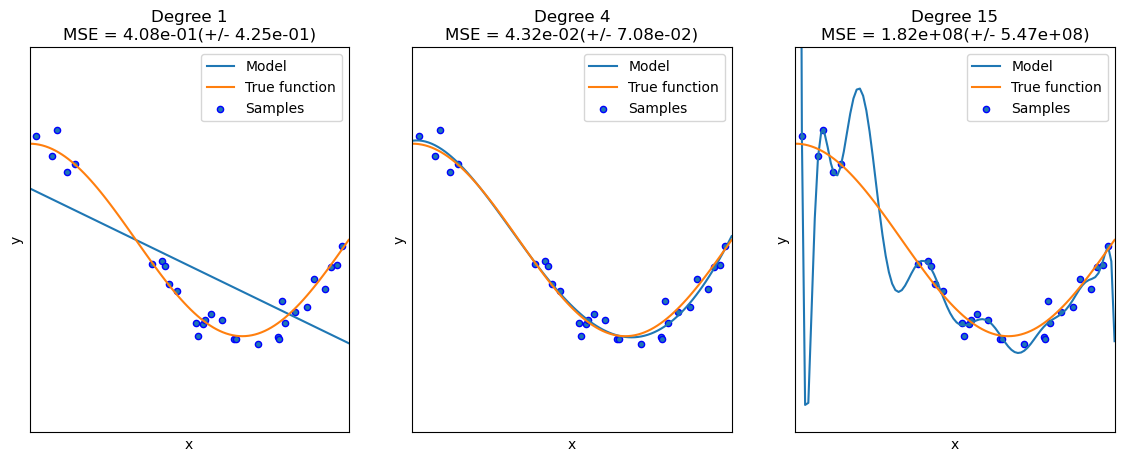

In [3]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

## Train-test split

we will use the Kaggle Food Demand Forecasting data to demonstrate these major steps.
- Data https://kaggle.com/datasets/kannanaikkal/food-demand-forecasting/

In [4]:
# Import data from kaggle competition
PATH = "./data/food_demand"
df = pd.read_csv(os.path.join(PATH, "train.csv"), index_col=0)
# test_data = pd.read_csv(os.path.join(PATH, "test.csv"), index_col=0)

meal_info_df = pd.read_csv(os.path.join(PATH, "meal_info.csv"), index_col=0)
meal_info_df = meal_info_df.reset_index(
    drop=False  # старий індекс не буде видалено, а буде перетворений у звичайний стовпець DataFrame.
)

meal_info_df[["category", "meal_id"]].groupby(["category"]).count()
df = df.merge(meal_info_df, on="meal_id", how="left")

df.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian


In [5]:
df.tail()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
456543,145,61,1543,484.09,484.09,0,0,68,Desert,Indian
456544,145,61,2304,482.09,482.09,0,0,42,Desert,Indian
456545,145,61,2664,237.68,321.07,0,0,501,Salad,Italian
456546,145,61,2569,243.50,313.34,0,0,729,Salad,Italian
456547,145,61,2490,292.03,290.03,0,0,162,Salad,Italian


In [6]:
df.cuisine.unique()

array(['Thai', 'Indian', 'Italian', 'Continental'], dtype=object)

In [7]:
# Вибираємо замовлення з магазину з ID 55, які стосуються тайської кухні
df_slice = df[(df["center_id"] == 55) & (df["cuisine"] == "Thai")]
df_slice = df_slice[["checkout_price", "num_orders"]]

# sorted by checkout_price
df_slice = df_slice.sort_values(by="checkout_price", ascending=False, axis=0)
df_slice.reset_index(
    drop=True,  #  Скидаємо старий індекс
    inplace=True,  # і створюємо новий послідовний індекс (0, 1, 2, ...), не зберігаючи старий як окрему колонку
)
df_slice

,checkout_price,num_orders
0,321.13,26
1,321.13,41
2,321.13,26
3,321.13,15
4,321.13,28
...,...,...
1274,80.54,55
1275,80.54,53
1276,80.54,54
1277,79.54,55


In [8]:
# train-test-split with sklearn
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_slice, shuffle=False, test_size=0.25)
train_data.tail()

,checkout_price,num_orders
954,146.5,68
955,146.5,285
956,146.5,204
957,146.5,82
958,146.5,94


In [9]:
test_data.head()

,checkout_price,num_orders
959,146.5,94
960,146.5,284
961,146.5,121
962,146.5,163
963,146.5,203


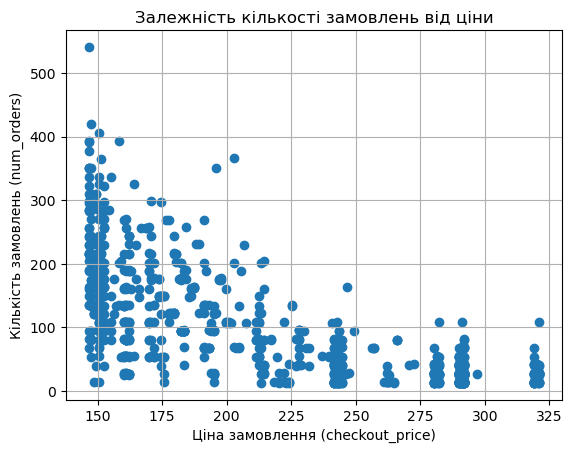

In [10]:
plt.scatter(train_data["checkout_price"], train_data["num_orders"])
plt.xlabel("Ціна замовлення (checkout_price)")
plt.ylabel("Кількість замовлень (num_orders)")
plt.title("Залежність кількості замовлень від ціни")
plt.grid(True)
plt.show()

In [11]:
# Чому не треба дивитись на графік із test_data?
# Якщо ти робиш графік або аналіз на тестових даних перед тим, як побудував модель, то це нормально — це як "контрольна перевірка".

# Але якщо ти дивишся на тестові дані, щоб налаштовувати модель або робиш аналіз, який потім впливає на тренування — ти "дивишся у майбутнє", і це є витік даних.

# Тобто, тестові дані мають бути "чистими", не відомими моделі до кінця тренування.


# plt.scatter(test_data["checkout_price"], test_data["num_orders"])
# plt.xlabel("Ціна замовлення (checkout_price)")
# plt.ylabel("Кількість замовлень (num_orders)")
# plt.title("Залежність кількості замовлень від ціни")
# plt.grid(True)
# plt.show()

<h3>Коротка інструкція, щоб уникнути Data Leakage</h3>
<ol>
  <li><strong>Чітко розділяй дані на тренувальні (train) і тестові (test)</strong> одразу, до будь-яких операцій з даними.</li>
  <li><strong>Використовуй тестові дані лише для фінальної оцінки моделі</strong>, після того, як модель повністю навчена і налаштована.</li>
  <li><strong>Не дивись, не аналізуй і не використовуй інформацію з тестових даних під час навчання або підбору параметрів моделі.</strong></li>
  <li><strong>Якщо робиш трансформації даних (нормалізація, масштабування, відбір ознак),</strong> навчати їх тільки на тренувальних даних і застосовувати до тестових.</li>
  <li><strong>Не використовуйте тестові дані для візуалізації під час підготовки моделі</strong> (щоб уникнути підсвідомого налаштування моделі під них).</li>
</ol>
<p>Це допоможе отримати реалістичну оцінку якості моделі і запобігти завищеним результатам.</p>


In [12]:
from sklearn.linear_model import LinearRegression

x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)

In [13]:
train_data["predictions"] = model.predict(x)
x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

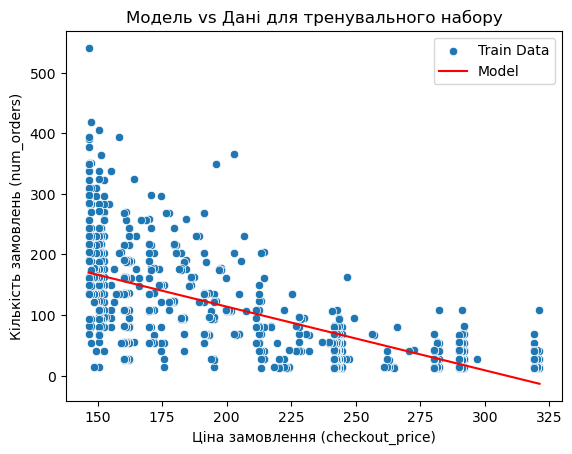

In [14]:
# Train
sns.scatterplot(x="checkout_price", y="num_orders", data=train_data, label="Train Data")
sns.lineplot(
    x="checkout_price", y="predictions", data=train_data, color="red", label="Model"
)
# Додаткові елементи
plt.xlabel("Ціна замовлення (checkout_price)")
plt.ylabel("Кількість замовлень (num_orders)")
plt.title("Модель vs Дані для тренувального набору")
plt.legend()
plt.show()

<Axes: xlabel='checkout_price', ylabel='num_orders'>

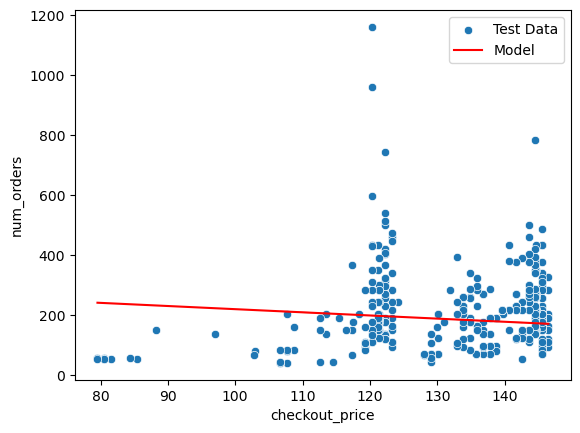

In [15]:
# Test
sns.scatterplot(x="checkout_price", y="num_orders", data=test_data, label="Test Data")
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data, color="red", label="Model"
)

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error_train = mean_squared_error(
    train_data["num_orders"], train_data["predictions"]
)
print(f"Train MSE: {mean_squared_error_train:.2f}")
mean_squared_error_test = mean_squared_error(
    test_data["num_orders"], test_data["predictions"]
)
print(f"Test MSE: {mean_squared_error_test:.2f}")

Train MSE: 3621.02
Test MSE: 20190.87


<table>
  <thead>
    <tr>
      <th>Причина</th>
      <th>Ознака</th>
      <th>Рішення</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>Overfitting</b></td>
      <td>Test MSE ≫ Train MSE</td>
      <td>Спрощення моделі, регуляризація</td>
    </tr>
    <tr>
      <td><b>Розбіжність у Train/Test</b></td>
      <td>Test ≠ Train розподіл</td>
      <td>Рандомізація, перевірка розподілів</td>
    </tr>
    <tr>
      <td><b>Мало тренувальних даних</b></td>
      <td>Висока похибка на тесті</td>
      <td>Збір або генерація нових даних</td>
    </tr>
    <tr>
      <td><b>Шум або погані фічі</b></td>
      <td>Модель "вгадує"</td>
      <td>Відбір ознак (feature selection)</td>
    </tr>
    <tr>
      <td><b>Погане масштабування</b></td>
      <td>Високий MSE</td>
      <td>Стандартизація/нормалізація</td>
    </tr>
  </tbody>
</table>


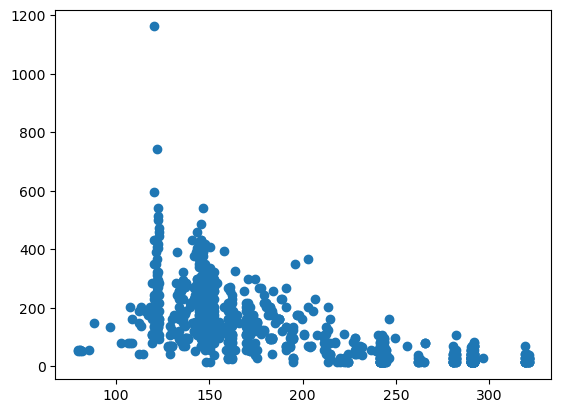

In [17]:
# Shaffle
train_data, test_data = train_test_split(
    df_slice, shuffle=True, test_size=0.25,
)
plt.scatter(
    train_data["checkout_price"], train_data["num_orders"], label="Train Data"
)

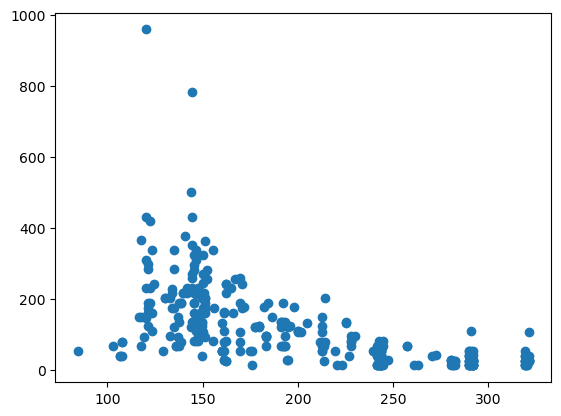

In [18]:
plt.scatter(
    test_data["checkout_price"], test_data["num_orders"], label="Test Data"
)

In [19]:
x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)
train_data["predictions"] = model.predict(x)

x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

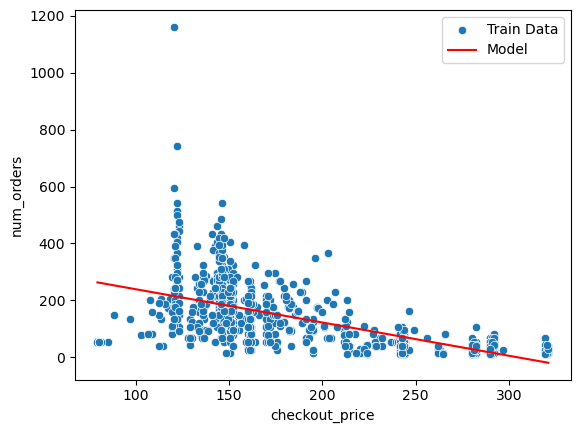

In [20]:
sns.scatterplot(
    x="checkout_price", y="num_orders", data=train_data, label="Train Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=train_data, color="red", label="Model"
)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

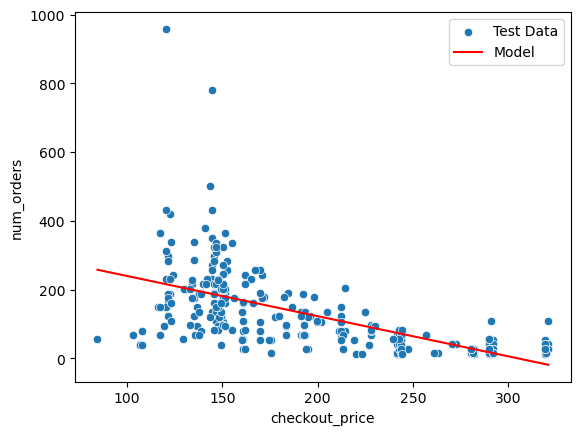

In [21]:
sns.scatterplot(
    x="checkout_price", y="num_orders", data=test_data, label="Test Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data, color="red", label="Model"
)

In [22]:
mean_squared_error_train = mean_squared_error(
    train_data["num_orders"], train_data["predictions"]
)
print(f"Train MSE: {mean_squared_error_train:.2f}")
mean_squared_error_test = mean_squared_error(
    test_data["num_orders"], test_data["predictions"]
)
print(f"Test MSE: {mean_squared_error_test:.2f}")

Train MSE: 7478.46
Test MSE: 8253.62


<h3>📈 Висновки по якості моделі</h3>

<ul>
  <li><b>Train MSE:</b> 7478.46</li>
  <li><b>Test MSE:</b> 8253.62</li>
</ul>

<p>✅ <b>Результати свідчать про хорошу узагальнюваність моделі:</b></p>

<ul>
  <li>Помилки на тренувальних і тестових даних подібні — <b>немає overfitting</b></li>
  <li>Модель не просто запам'ятала дані, а <b>навчилася робити передбачення</b> на нових прикладах</li>
  <li>Різниця між Train і Test MSE становить менше ніж 10% — <b>це дуже добре</b></li>
</ul>

<h4>🛠️ Рекомендації:</h4>
<ul>
  <li>Можна додатково проаналізувати важливість ознак (feature importance)</li>
  <li>Перевірити залишки (residuals), щоб знайти, де модель найбільше помиляється</li>
  <li>Розглянути інші метрики: MAE, R², MAPE тощо</li>
  <li>Можна спробувати легкий тюнінг гіперпараметрів або ансамблювання</li>
</ul>


## Cross Validation

https://scikit-learn.org/stable/modules/cross_validation.html

<p align="center">
  <img src="./data/grid_search_cross_validation.png" alt="Cross Validation" width="500"/>
</p>

In [23]:
from sklearn import model_selection

X = range(10)
X

range(0, 10)

In [24]:
kf = model_selection.KFold(n_splits=5)
for train_indices, test_indices in kf.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    

TRAIN: [2 3 4 5 6 7 8 9] TEST: [0 1]
TRAIN: [0 1 4 5 6 7 8 9] TEST: [2 3]
TRAIN: [0 1 2 3 6 7 8 9] TEST: [4 5]
TRAIN: [0 1 2 3 4 5 8 9] TEST: [6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]


In [25]:
kf = model_selection.KFold(n_splits=2, shuffle=True)
for train_indices, test_indices in kf.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)

TRAIN: [0 1 3 5 8] TEST: [2 4 6 7 9]
TRAIN: [2 4 6 7 9] TEST: [0 1 3 5 8]


In [26]:
kf = model_selection.KFold(n_splits=2, shuffle=True, random_state=1)
for train_indices, test_indices in kf.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    print("TRAIN labels:", y[train_indices])
    print("TEST labels:", y[test_indices])

TRAIN: [1 3 5 7 8] TEST: [0 2 4 6 9]
TRAIN labels: [ 96  80 121  80 460]
TEST labels: [ 27  14  15 162 176]
TRAIN: [0 2 4 6 9] TEST: [1 3 5 7 8]
TRAIN labels: [ 27  14  15 162 176]
TEST labels: [ 96  80 121  80 460]


In [27]:
X = range(12)

In [28]:
y = np.array([0] * 6 + [1] * 6)  # 0 for first 6, 1 for next 6
print(y)

skf = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
for train_indices, test_indices in skf.split(X, y):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    print("TRAIN labels:", y[train_indices])
    print("TEST labels:", y[test_indices])

[0 0 0 0 0 0 1 1 1 1 1 1]
TRAIN: [ 0  3  5  7  8 11] TEST: [ 1  2  4  6  9 10]
TRAIN labels: [0 0 0 1 1 1]
TEST labels: [0 0 0 1 1 1]
TRAIN: [ 1  2  4  6  9 10] TEST: [ 0  3  5  7  8 11]
TRAIN labels: [0 0 0 1 1 1]
TEST labels: [0 0 0 1 1 1]


In [29]:
y = np.array([0, 1] * 6)  # 0 for first 6, 1 for next 6
print(y)

skf = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
for train_indices, test_indices in skf.split(X, y):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    print("TRAIN labels:", y[train_indices])
    print("TEST labels:", y[test_indices])
# StratifiedKFold ensures that each fold has the same proportion of classes as the entire dataset.
# This is particularly useful for imbalanced datasets, where one class may be underrepresented.

[0 1 0 1 0 1 0 1 0 1 0 1]
TRAIN: [ 0  3  5  6 10 11] TEST: [1 2 4 7 8 9]
TRAIN labels: [0 1 1 0 0 1]
TEST labels: [1 0 0 1 0 1]
TRAIN: [1 2 4 7 8 9] TEST: [ 0  3  5  6 10 11]
TRAIN labels: [1 0 0 1 0 1]
TEST labels: [0 1 1 0 0 1]


In [30]:
ss = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)

for train_indices, test_indices in ss.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)
# ShuffleSplit randomly splits the data into training and testing sets multiple times, without preserving the class distribution.

TRAIN: [ 6  5  8 11  4  1  0  7 10] TEST: [3 9 2]
TRAIN: [ 3 11  6  2  8  9  4  5 10] TEST: [0 1 7]
TRAIN: [ 6  7  5 10  1  9  8  0  3] TEST: [ 2  4 11]
TRAIN: [ 6 11 10  0  4  5  9  3  2] TEST: [7 8 1]
TRAIN: [ 5  7  6 10  0 11  4  1  8] TEST: [2 3 9]
TRAIN: [ 4  7  8  5  6 10  3  0  9] TEST: [ 2 11  1]
TRAIN: [ 9  0 10  3  1  2 11  5  8] TEST: [4 6 7]
TRAIN: [ 4  0  9  1 11  7  2  6  8] TEST: [ 3  5 10]
TRAIN: [ 8  4  9  0  1  2 11  3 10] TEST: [5 7 6]
TRAIN: [ 9  4 10  8  7  1 11  2  3] TEST: [0 6 5]


In [31]:
X = range(10)
target = np.array([0] * 5 + [1] * 5)  # 0 for first 5, 1 for next 5 
print(target)

sss = model_selection.StratifiedShuffleSplit(n_splits=4, test_size=0.2)
for train_indices, test_indices in sss.split(X, target):
    print("TRAIN:", train_indices, "TEST:", test_indices)

[0 0 0 0 0 1 1 1 1 1]
TRAIN: [2 5 4 1 6 7 9 3] TEST: [8 0]
TRAIN: [4 6 8 7 5 2 0 3] TEST: [9 1]
TRAIN: [7 8 4 6 0 1 3 9] TEST: [2 5]
TRAIN: [9 4 0 2 6 7 8 1] TEST: [5 3]


In [32]:
loo = model_selection.LeaveOneOut()

for train_indices, test_indices in loo.split(X):
    print("TRAIN:", train_indices, "TEST:", test_indices)

TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


## Regularization
Ridge Regression: in ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients.

Classic linear regression:

$$
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p
$$

**Where:**

- $\hat{y}$ : predicted value (output)  
- $\beta_0$ : intercept (bias term)  
- $\beta_1, \beta_2, \dots, \beta_p$ : model coefficients (weights)  
- $x_1, x_2, \dots, x_p$ : input features (predictors)

---

Sum of squares in classic linear regression:

$$
\text{SSE} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 = \sum_{i=1}^{n} \left( y_i - \sum_{j=0}^{p} w_j x_{ij} \right)^2
$$

$$
\text{SSE} = \sum_{i=1}^{n} \left( y_i - \sum_{j=0}^{p} \beta_j x_{ij} \right)^2
$$

📌 **Пояснення:**

- $y_i$ — фактичне (спостережуване) значення  
- $\hat{y}_i$ — передбачене значення моделі  
- $w_j$ — коефіцієнти моделі (аналогічно $\beta_j$)  
- $x_{ij}$ — значення j-ї ознаки для i-го спостереження  
- $p$ — кількість ознак  
- $n$ — кількість спостережень

## Lasso
**Lasso-модель мінімізує функцію втрат:**

$$
\text{Loss} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{p} |w_j|
$$

де:
- перший доданок — це звичайна середньоквадратична похибка (MSE)  
- другий доданок — $L_1$-штраф, який сприяє обнуленню деяких $w_j$ (відбір ознак)

📌 **Пояснення: Lasso-регресія**

- $y_i$ — фактичне (спостережуване) значення  
- $\hat{y}_i$ — передбачене значення моделі  
- $w_j$ — коефіцієнти моделі  
- $x_{ij}$ — значення j-ї ознаки для i-го спостереження  
- $p$ — кількість ознак  
- $n$ — кількість спостережень  
- $\lambda$ — коефіцієнт регуляризації (визначає силу штрафу)  

**Lasso-модель мінімізує функцію втрат:**

$$
\text{Loss} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{p} |w_j|
$$

де:
- перший доданок — це звичайна середньоквадратична похибка (MSE)  
- другий доданок — $L_1$-штраф, який сприяє обнуленню деяких $w_j$ (відбір ознак)

## Ridge
**Ridge-модель мінімізує функцію втрат:**

$$
\text{Loss} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{p} w_j^2
$$

де:
- перший доданок — це звичайна середньоквадратична похибка (MSE)  
- другий доданок — $L_2$-штраф, який зменшує величину коефіцієнтів, але не зануляє їх


📌 **Пояснення: Ridge-регресія**

- $y_i$ — фактичне (спостережуване) значення  
- $\hat{y}_i$ — передбачене значення моделі  
- $w_j$ — коефіцієнти моделі  
- $x_{ij}$ — значення j-ї ознаки для i-го спостереження  
- $p$ — кількість ознак  
- $n$ — кількість спостережень  
- $\lambda$ — коефіцієнт регуляризації (визначає силу штрафу)  

##  Elastic Net
**Elastic Net мінімізує функцію втрат:**

$$
\text{Loss} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \left( \alpha \sum_{j=1}^p |w_j| + (1-\alpha) \sum_{j=1}^p w_j^2 \right)
$$

де:  
- перший доданок — середньоквадратична похибка (MSE)  
- другий доданок — комбінований штраф, що поєднує $L_1$ (Lasso) та $L_2$ (Ridge) регуляризації

📌 **Пояснення: Elastic Net**

- $y_i$ — фактичне (спостережуване) значення  
- $\hat{y}_i$ — передбачене значення моделі  
- $w_j$ — коефіцієнти моделі  
- $x_{ij}$ — значення j-ї ознаки для i-го спостереження  
- $p$ — кількість ознак  
- $n$ — кількість спостережень  
- $\lambda$ — загальний коефіцієнт регуляризації  
- $\alpha$ — параметр балансу між $L_1$ та $L_2$ штрафами (0 ≤ α ≤ 1)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

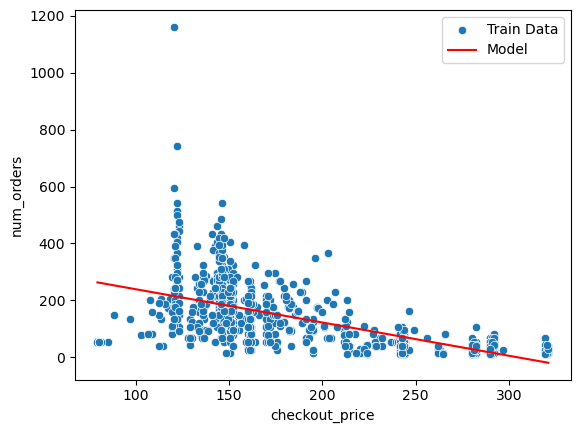

In [33]:
x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)
train_data["predictions"] = model.predict(x)

x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

sns.scatterplot(
    x="checkout_price", y="num_orders", data=train_data, label="Train Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=train_data, color="red", label="Model"
)

In [34]:
mean_squared_error_train = mean_squared_error(
    train_data["num_orders"], train_data["predictions"]
)
print(f"Train MSE: {mean_squared_error_train:.2f}")
mean_squared_error_test = mean_squared_error(
    test_data["num_orders"], test_data["predictions"]
)
print(f"Test MSE: {mean_squared_error_test:.2f}")

Train MSE: 7478.46
Test MSE: 8253.62


In [35]:
model.coef_

array([-1.16828049])

In [36]:
from copy import deepcopy
coefs = [
    -2.0,
    -1.7,
    -1.4,
    -1.16981158,
    -1.16828049,
    -0.99,
    -0.97,
    -0.84,
    -0.64,
    -0.5,
    -0.2,
    0.01,
    0.2,
    0.45,
    0.76,
    0.99,
    1.2,
]

models = []
for coef in coefs:
    new_model = deepcopy(model)
    new_model.coef_ = np.array([coef])
    models.append(new_model)

for i in range(len(models)):
    test_data[f"exp{i}"] = models[i].predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

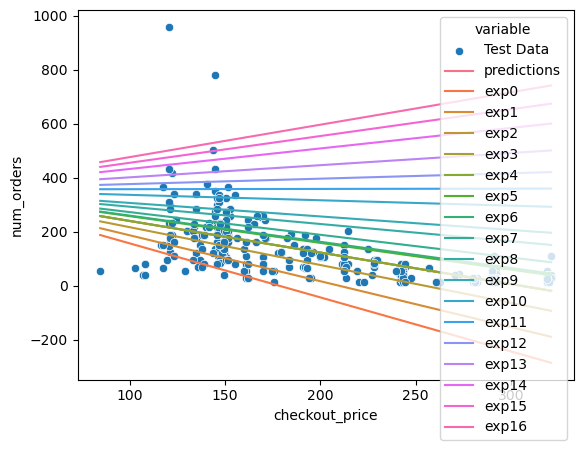

In [37]:
sns.scatterplot(
    x="checkout_price", y="num_orders", data=test_data, label="Test Data"
)
sns.lineplot(
    x="checkout_price", y="value", hue="variable", data=pd.melt(test_data.drop(["num_orders"], axis=1), ["checkout_price"])
)

Loss for model 0: 36741.77
Loss for model 1: 19589.22
Loss for model 2: 10196.68
Loss for model 3: 8251.26
Loss for model 4: 8253.62
Loss for model 5: 9909.88
Loss for model 6: 10266.64
Loss for model 7: 13426.29
Loss for model 8: 21132.62
Loss for model 9: 28579.14
Loss for model 10: 50226.66
Loss for model 11: 69997.13
Loss for model 12: 91161.15
Loss for model 13: 123750.77
Loss for model 14: 171646.00
Loss for model 15: 212535.58
Loss for model 16: 253853.02


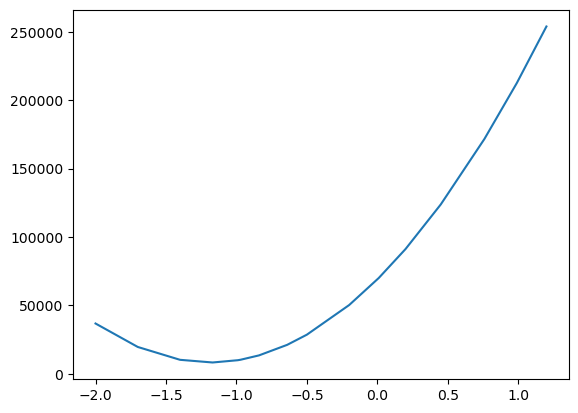

In [38]:
losses = []
for i, model in enumerate(models):
    loss = mean_squared_error(test_data["num_orders"], test_data[f"exp{i}"])
    losses.append(loss)
    print(f"Loss for model {i}: {loss:.2f}")
plt.plot(np.array(coefs), np.array(losses), label = "MSE")

<Axes: xlabel='checkout_price', ylabel='num_orders'>

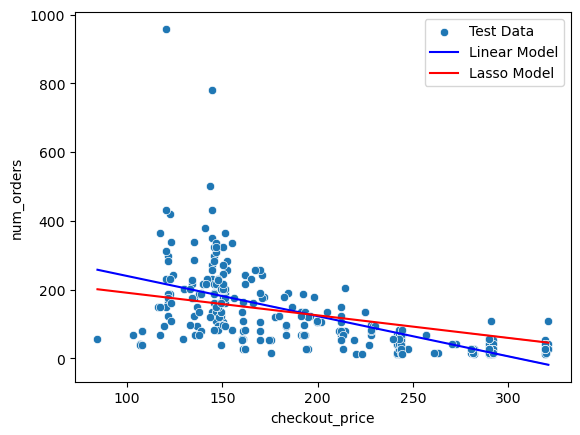

In [39]:
from sklearn.linear_model import Ridge, Lasso

model_lasso = Lasso(alpha=2_000).fit(x, y)

test_data_lasso = test_data[:]

x_test = test_data_lasso["checkout_price"].to_numpy().reshape(-1, 1)
test_data_lasso["predictions"] = model_lasso.predict(x_test)

sns.scatterplot(
    x="checkout_price", y="num_orders", data=test_data_lasso, label="Test Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data, color="blue", label="Linear Model"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data_lasso, color="red", label="Lasso Model")


In [40]:
mean_squared_error_test_lasso = mean_squared_error(
    test_data_lasso["num_orders"], test_data_lasso["predictions"]
)
print(f"Test MSE Lasso: {mean_squared_error_test_lasso:.2f}")
# Lasso tends to shrink some coefficients to zero, effectively performing feature selection.

Test MSE Lasso: 8932.53


In [41]:
model_lasso.coef_, model_lasso.intercept_

(array([-0.65656603]), np.float64(256.34780129463945))

Loss for Lasso model 0: 78521.18
Loss for Lasso model 1: 49486.35
Loss for Lasso model 2: 28211.54
Loss for Lasso model 3: 17148.91
Loss for Lasso model 4: 17090.62
Loss for Lasso model 5: 11685.62
Loss for Lasso model 6: 11250.24
Loss for Lasso model 7: 9260.89
Loss for Lasso model 8: 9045.71
Loss for Lasso model 9: 10947.17
Loss for Lasso model 10: 20712.41
Loss for Lasso model 11: 32165.29
Loss for Lasso model 12: 45803.86
Loss for Lasso model 13: 68491.59
Loss for Lasso model 14: 104108.47
Loss for Lasso model 15: 135888.31
Loss for Lasso model 16: 168888.15


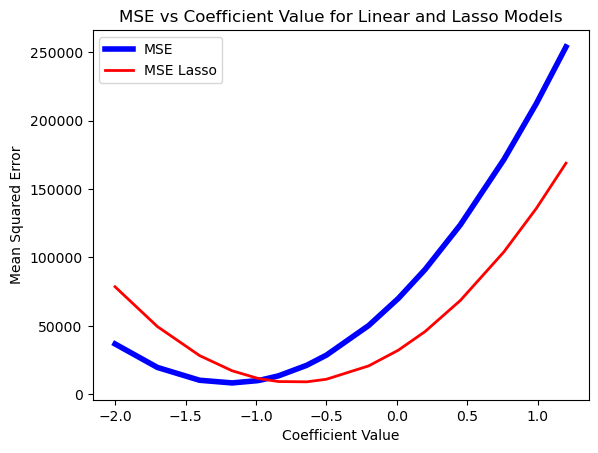

In [42]:
coefs = [-2.0, -1.7, -1.4, -1.16981158, -1.16828049, -0.99, -0.97, -0.84, -0.64, -0.5, -0.2, 0.01, 0.2, 0.45, 0.76, 0.99, 1.2]

models_lasso = []
for coef in coefs:
    new_model = deepcopy(model_lasso)
    new_model.coef_ = np.array([coef])
    models_lasso.append(new_model)

for i in range(len(models_lasso)):
    test_data_lasso[f"exp{i}"] = models_lasso[i].predict(x_test)

losses_lasso = []
for i in range(len(models_lasso)):
    mse = mean_squared_error(test_data_lasso["num_orders"], test_data_lasso[f"exp{i}"])
    losses_lasso.append(mse)
    print(f"Loss for Lasso model {i}: {mse:.2f}")

plt.plot(np.array(coefs), np.array(losses), label="MSE", color='blue', linewidth=4 )
plt.plot(np.array(coefs), np.array(losses_lasso), label="MSE Lasso", color='red', linewidth=2)
plt.xlabel("Coefficient Value")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs Coefficient Value for Linear and Lasso Models")
plt.legend()
plt.show()

Loss for Lasso model 0 with alpha 0: 36741.77
Loss for Lasso model 1 with alpha 1: 19589.22
Loss for Lasso model 2 with alpha 2: 10196.68
Loss for Lasso model 3 with alpha 3: 8251.26
Loss for Lasso model 4 with alpha 4: 8253.62
Loss for Lasso model 5 with alpha 5: 9909.88
Loss for Lasso model 6 with alpha 6: 10266.64
Loss for Lasso model 7 with alpha 7: 13426.29
Loss for Lasso model 8 with alpha 8: 21132.62
Loss for Lasso model 9 with alpha 9: 28579.14
Loss for Lasso model 10 with alpha 10: 50226.66
Loss for Lasso model 11 with alpha 11: 69997.13
Loss for Lasso model 12 with alpha 12: 91161.15
Loss for Lasso model 13 with alpha 13: 123750.77
Loss for Lasso model 14 with alpha 14: 171646.00
Loss for Lasso model 15 with alpha 15: 212535.58
Loss for Lasso model 16 with alpha 16: 253853.02
Loss for Lasso model 0 with alpha 0: 45313.21
Loss for Lasso model 1 with alpha 1: 25190.09
Loss for Lasso model 2 with alpha 2: 12826.98
Loss for Lasso model 3 with alpha 3: 8602.26
Loss for Lasso model

/home/sergio/anaconda3/envs/conda_env_example/lib/python3.11/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/sergio/anaconda3/envs/conda_env_example/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/sergio/anaconda3/envs/conda_env_example/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.586e+06, tolerance: 1.229e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the sol

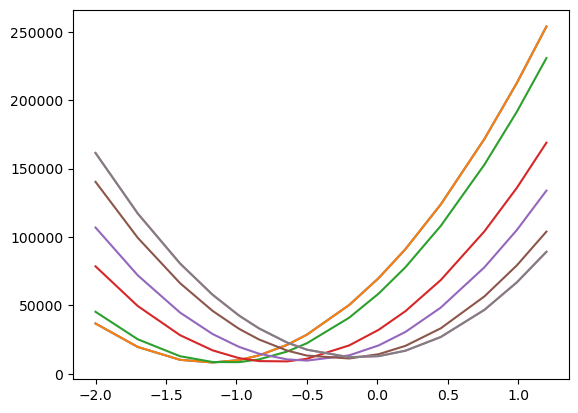

In [43]:
plt.plot(np.array(coefs), np.array(losses), label="MSE")

losses_lasso_all = [losses]

for i in [0, 500, 2000, 3000, 4000, 5000, 10_000]:
    model_lasso = Lasso(alpha=i).fit(x, y)

    x_test = test_data_lasso["checkout_price"].to_numpy().reshape(-1, 1)
    test_data_lasso["predictions"] = model_lasso.predict(x_test)
    models_lasso = []
    for coef in coefs:
        new_model = deepcopy(model_lasso)
        new_model.coef_ = np.array([coef])
        models_lasso.append(new_model)

    for i in range(len(models_lasso)):
        test_data_lasso[f"exp{i}"] = models_lasso[i].predict(x_test)

    losses_lasso = []
    for i, model in enumerate(models_lasso):
        mse = mean_squared_error(test_data_lasso["num_orders"], test_data_lasso[f"exp{i}"])
        losses_lasso.append(mse)
        print(f"Loss for Lasso model {i} with alpha {i}: {mse:.2f}")

    losses_lasso_all.append(losses_lasso)
    plt.plot(np.array(coefs), np.array(losses_lasso), label="MSE")


In [44]:
losses_lasso_all

[[36741.771308998075,
  19589.21855864078,
  10196.679468058483,
  8251.262404401647,
  8253.617667304006,
  9909.87591293214,
  10266.641703798154,
  13426.287490902867,
  21132.619351443,
  28579.144154961592,
  50226.6597034793,
  69997.12871500783,
  91161.14612781958,
  123750.7680303291,
  171646.00125242394,
  212535.58371341648,
  253853.02398692025],
 [36741.77130899811,
  19589.2185586408,
  10196.679468058494,
  8251.262404401647,
  8253.617667304004,
  9909.87591293213,
  10266.641703798145,
  13426.28749090285,
  21132.61935144298,
  28579.14415496157,
  50226.65970347925,
  69997.12871500776,
  91161.14612781952,
  123750.76803032905,
  171646.00125242388,
  212535.5837134164,
  253853.0239869201],
 [45313.2070759442,
  25190.085294361255,
  12826.977172553314,
  8602.258136233937,
  8589.452704009564,
  8480.395941418587,
  8639.123796869559,
  10511.52300377649,
  16237.475510166196,
  22297.73476577949,
  40974.68128307154,
  58665.75197274211,
  77948.40899911096,
  1

In [45]:
#   8251.262404401647

Test MSE Ridge: 8253.21


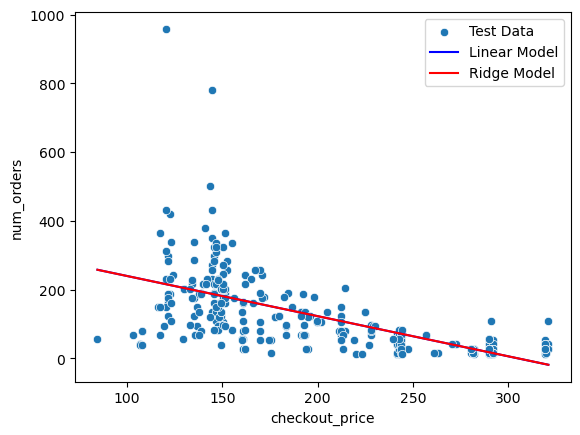

In [46]:
model_ridge = Ridge(alpha=2_000).fit(x, y)

test_data_ridge = test_data[:]

x_test = test_data_ridge["checkout_price"].to_numpy().reshape(-1, 1)
test_data_ridge["predictions"] = model_ridge.predict(x_test)

sns.scatterplot(
    x="checkout_price", y="num_orders", data=test_data_ridge, label="Test Data"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data, color="blue", label="Linear Model"
)
sns.lineplot(
    x="checkout_price", y="predictions", data=test_data_ridge, color="red", label="Ridge Model"
)

mean_squared_error_test_ridge = mean_squared_error(
    test_data_ridge["num_orders"], test_data_ridge["predictions"]
)
print(f"Test MSE Ridge: {mean_squared_error_test_ridge:.2f}")

Loss for Ridge model 0 with alpha 0: 36741.77
Loss for Ridge model 1 with alpha 1: 19589.22
Loss for Ridge model 2 with alpha 2: 10196.68
Loss for Ridge model 3 with alpha 3: 8251.26
Loss for Ridge model 4 with alpha 4: 8253.62
Loss for Ridge model 5 with alpha 5: 9909.88
Loss for Ridge model 6 with alpha 6: 10266.64
Loss for Ridge model 7 with alpha 7: 13426.29
Loss for Ridge model 8 with alpha 8: 21132.62
Loss for Ridge model 9 with alpha 9: 28579.14
Loss for Ridge model 10 with alpha 10: 50226.66
Loss for Ridge model 11 with alpha 11: 69997.13
Loss for Ridge model 12 with alpha 12: 91161.15
Loss for Ridge model 13 with alpha 13: 123750.77
Loss for Ridge model 14 with alpha 14: 171646.00
Loss for Ridge model 15 with alpha 15: 212535.58
Loss for Ridge model 16 with alpha 16: 253853.02
Loss for Ridge model 0 with alpha 0: 36751.45
Loss for Ridge model 1 with alpha 1: 19595.28
Loss for Ridge model 2 with alpha 2: 10199.12
Loss for Ridge model 3 with alpha 3: 8250.93
Loss for Ridge model

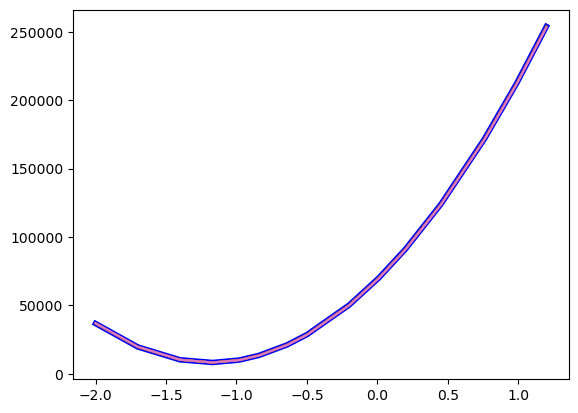

In [47]:
plt.plot(np.array(coefs), np.array(losses), label="MSE", color='blue', linewidth=4 )

losses_ridge_all = []

for i in [0, 500, 2000, 3000, 4000, 5000, 10_000]:
    model_ridge = Ridge(alpha=i).fit(x, y)

    x_test = test_data_ridge["checkout_price"].to_numpy().reshape(-1, 1)
    test_data_ridge["predictions"] = model_ridge.predict(x_test)
    models_ridge = []
    for coef in coefs:
        new_model = deepcopy(model_ridge)
        new_model.coef_ = np.array([coef])
        models_ridge.append(new_model)

    for i in range(len(models_ridge)):
        test_data_ridge[f"exp{i}"] = models_ridge[i].predict(x_test)

    losses_ridge = []
    for i, model in enumerate(models_ridge):
        mse = mean_squared_error(test_data_ridge["num_orders"], test_data_ridge[f"exp{i}"])
        losses_ridge.append(mse)
        print(f"Loss for Ridge model {i} with alpha {i}: {mse:.2f}")

    losses_ridge_all.append(losses_ridge)
    plt.plot(np.array(coefs), np.array(losses_ridge), label="MSE")

In [48]:
losses_ridge_all

[[36741.7713089981,
  19589.21855864079,
  10196.679468058488,
  8251.262404401647,
  8253.617667304004,
  9909.875912932135,
  10266.641703798148,
  13426.287490902858,
  21132.61935144299,
  28579.14415496158,
  50226.65970347928,
  69997.1287150078,
  91161.14612781955,
  123750.76803032907,
  171646.00125242388,
  212535.58371341642,
  253853.02398692016],
 [36751.45215659599,
  19595.281059035846,
  10199.123621250701,
  8250.930218841746,
  8253.267015026708,
  9907.374991613795,
  10263.899559332951,
  13421.977395983096,
  21125.897025054663,
  28570.733266545263,
  50214.63046786011,
  69982.56663634663,
  91144.29242926325,
  123730.89904243709,
  171622.39330575563,
  212509.2017005593,
  253824.10913102105],
 [36780.49031864473,
  19613.46996854739,
  10206.46327822505,
  8249.945301483702,
  8252.226727061774,
  9899.887336787311,
  10255.688621003987,
  13409.065114888013,
  21105.751908934784,
  28545.525165908028,
  50178.57311468568,
  69938.91480639616,
  91093.769406

In [49]:
# 8251.262404401647,

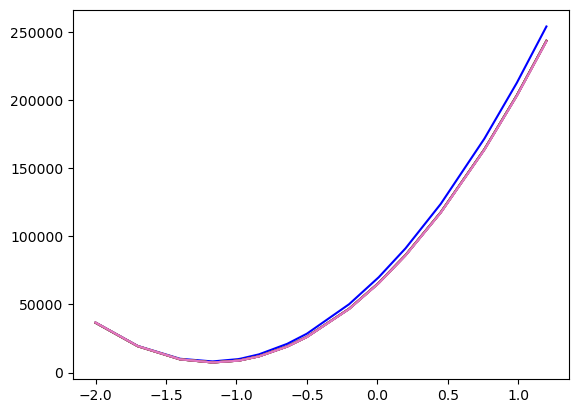

In [50]:
plt.plot(np.array(coefs), np.array(losses), label="MSE", color="blue")

losses_ridge_all = []

train_data_ridge = train_data[:]

for i in [0, 500, 2000, 3000, 4000, 5000, 10_000]:
    model_ridge = Ridge(alpha=i).fit(x, y)

    train_data_ridge["predictions"] = model_ridge.predict(x)
    models_ridge = []
    for coef in coefs:
        new_model = deepcopy(model_ridge)
        new_model.coef_ = np.array([coef])
        models_ridge.append(new_model)

    for i in range(len(models_ridge)):
        train_data_ridge[f"exp{i}"] = models_ridge[i].predict(x)

    losses_ridge = []
    for i, model in enumerate(models_ridge):
        mse = mean_squared_error(
            train_data_ridge["num_orders"], train_data_ridge[f"exp{i}"]
        )
        losses_ridge.append(mse)

    losses_ridge_all.append(losses_ridge)
    plt.plot(np.array(coefs), np.array(losses_ridge), label="MSE")

### Hyperparameter tuning

Examples

- $Параметер регуляризаціі \lambda$
- Ступінь полінома в задачі регресії з сімейством алгоритмів, заданим безліччю поліномів деякого ступеня
- learning rate
- ...

<p align="center">
  <img src="./data/traing_data-validation-test.avif" alt="Training data / Validation / test" width="500"/>
</p>

test ~ 15%, validation = (100% - 15%) * 10%, rest - training data

In [57]:
m = LinearRegression().fit(x, y)
y_test = test_data["num_orders"].to_numpy()
m.score(x_test, y_test)  # the coefficient of determination of the prediction(R^2 score).

0.34950196296612424

In [58]:
from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit

m = LinearRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(m, x, y, cv=cv)
scores, np.mean(scores), np.std(scores)

(array([0.46780125, 0.44824487, 0.38389073, 0.44793372, 0.40478883]),
 np.float64(0.430531881163032),
 np.float64(0.031124530126542944))

In [59]:
m = Ridge(3_000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores), np.std(scores)

(array([0.37807555, 0.54123965, 0.4183379 , 0.33134929, 0.42579396]),
 np.float64(0.41895926930435035),
 np.float64(0.06978048032155662))

In [60]:
m = Ridge(5_000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores), np.std(scores)

(array([0.37810066, 0.54126547, 0.41834641, 0.33125056, 0.42595321]),
 np.float64(0.41898326264774644),
 np.float64(0.06981452591860633))

In [61]:
m = Lasso(2_000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores), np.std(scores)

(array([0.31863809, 0.43776207, 0.34249314, 0.21777693, 0.40221298]),
 np.float64(0.3437766432028767),
 np.float64(0.07583875903024016))

In [62]:
m = Lasso(4_000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores), np.std(scores)

(array([0.10673551, 0.09221888, 0.10283705, 0.01431282, 0.12882813]),
 np.float64(0.08898647788946898),
 np.float64(0.0391939477223673))

In [63]:
import sklearn.metrics


m = LinearRegression().fit(x, y)
x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
y_test = test_data["num_orders"].to_numpy()
pred = m.predict(x_test)
sklearn.metrics.r2_score(y_test, pred)

0.34950196296612424